# Download dependencies/data

In [1]:
!curl -L https://www.dropbox.com/s/rndzndlgpw3coiq/kaggle-download.zip -o kaggle-download.zip
!unzip kaggle-download.zip -d kaggle_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     57      0 --:--:-- --:--:-- --:--:--    57
100   340  100   340    0     0    478      0 --:--:-- --:--:-- --:--:--     0
100   534    0   534    0     0    425      0 --:--:--  0:00:01 --:--:--   425
 41  515M   41  212M    0     0  46.1M      0  0:00:11  0:00:04  0:00:07 70.7M^C
Archive:  kaggle-download.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of kaggle-download.zip or
        kaggle-download.zip.zip, and cannot find kaggle-download.zip.ZIP, period.


In [ ]:
pip install xgboost

In [109]:
pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 840 kB 57.8 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 53.3 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492026 sha256=ec372d44630e94bb8052c2a3a28630c7890d98d786025dd7107cdf093e6684fb
  Stored in directory: /home/acz001/.cache/pip/wheels/bf/5d/6a/2e53874f7ec4e2bede522385439531fafec8fafe005b5c3d1b
Successfully built future
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import xgboost
import sklearn

# Processing data

In [2]:
df_taxi_data = pd.read_csv("kaggle_data/metaData_taxistandsID_name_GPSlocation.csv")
# The following code normalizes longitudes and latitudes.
# df_taxi_data["Longitude"] = (df_taxi_data["Longitude"] - df_taxi_data["Longitude"].mean()) / df_taxi_data["Longitude"].std()
# df_taxi_data["Latitude"] = (df_taxi_data["Latitude"] - df_taxi_data["Latitude"].mean()) / df_taxi_data["Latitude"].std()

In [3]:
from datetime import datetime
import math

def process_df(df):
    def parse_time(x):
        # We are using python's builtin datetime library
        # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

        # Each x is essentially a 1 row, 1 column pandas Series
        dt = datetime.fromtimestamp(x["TIMESTAMP"])
        return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

    def get_lat_long(x):
        if math.isnan(x["ORIGIN_STAND"]):
            return 0, 0
        taxi_row = df_taxi_data.iloc[int(x["ORIGIN_STAND"]) - 1]
        return float(taxi_row["Latitude"]), float(taxi_row["Longitude"])
    
    def augment_lat_long(df):
        if "POLYLINE" not in df:
            return df
        augmented_df = []
        for i, row in df.iterrows():
            if math.isnan(row["ORIGIN_STAND"]):
                    start = [i.replace(']', '').replace('[', '').split(',') for i in row["POLYLINE"].split('],')][0]
                    if len(start) == 2:
                        row.LATITUDE = float(start[0])
                        row.LONGITUDE = float(start[1])
                        augmented_df.append(row)
        return pd.concat([df, pd.DataFrame(augmented_df, columns=df.columns)], ignore_index=True)

    df[["LATITUDE", "LONGITUDE"]] = df.apply(get_lat_long, axis=1, result_type="expand")
    df[["YR", "MON", "DAY", "HR", "WK"]] = df.apply(parse_time, axis=1, result_type="expand")
    #df = augment_lat_long(df)
    df.drop(['TRIP_ID', "POLYLINE", 'MISSING_DATA', 'TAXI_ID', 'DAY_TYPE'], axis=1, inplace=True, errors="ignore")
    
    categorical_cols = ['CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'YR', 'MON', 'DAY', 'HR', 'WK']
    for col in categorical_cols:
        df[col] = df[col].astype('category')
    if 'LEN' in df.columns:
        df['LEN'] = df['LEN'].astype('float64')
    
    return df

## Do if you haven't run this notebook yet

In [5]:
# These are all of the files you are given
original_df_tr = pd.read_csv("kaggle_data/train.csv")

# getting rid of incomplete rows
original_rows = original_df_tr.shape[0]

df_tr = original_df_tr.loc[original_df_tr['MISSING_DATA'] == False]

rows_removed = original_rows - df_tr.shape[0]
print(f"{rows_removed=}")

rows_removed=10


In [7]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [ ]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

df_tr = process_df(df_tr)
df_tr.to_csv("processed_train.csv", index=False)

## Run if you already have "processed_train.csv" saved

In [8]:
df_tr = pd.read_csv("processed_train.csv")
categorical_cols = ['CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'YR', 'MON', 'DAY', 'HR', 'WK']
for col in categorical_cols:
    df_tr[col] = df_tr[col].astype('category')
if 'LEN' in df_tr.columns:
    df_tr['LEN'] = df_tr['LEN'].astype('float64')

## Run this in both cases

In [9]:
len_mean = df_tr['LEN'].mean()
len_std = df_tr['LEN'].std()
len_range = (len_mean - 3 * len_std, len_mean + 3 * len_std)
df_tr = df_tr.loc[df_tr['LEN'] < len_mean + 3 * len_std]

In [10]:
from sklearn.model_selection import train_test_split

X = df_tr.drop('LEN', axis=1)
y = df_tr['LEN']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

In [55]:
# Experimentation: trying a different model for each call type
a_df_tr = df_tr.loc[df_tr['CALL_TYPE'] == 'A']
b_df_tr = df_tr.loc[df_tr['CALL_TYPE'] == 'B']
c_df_tr = df_tr.loc[df_tr['CALL_TYPE'] == 'C']

In [57]:
a_df_tr.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TIMESTAMP,LEN,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK
12,A,31508.0,NaN,1372637343,465.0,0.0,0.0,2013,7,1,0,0
17,A,33180.0,NaN,1372639135,270.0,0.0,0.0,2013,7,1,0,0
21,A,39233.0,NaN,1372637254,630.0,0.0,0.0,2013,7,1,0,0
24,A,22864.0,NaN,1372637658,375.0,0.0,0.0,2013,7,1,0,0
26,A,25862.0,NaN,1372639535,840.0,0.0,0.0,2013,7,1,0,0


In [42]:
class CallType:
    def __init__(self, df):
        self.X = df.drop('LEN', axis=1)
        self.y = df['LEN']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, random_state=1, test_size=0.2)

In [43]:
callTypeModels = {"A": CallType(a_df_tr), "B": CallType(b_df_tr), "C": CallType(c_df_tr)}

## Data exploration

In [12]:
{ (x["YR"], x["MON"], x["DAY"]):x["DAY_TYPE"] for (i, x) in df_test.iterrows()}
# There are only Type A days in both the training and test datasets, so we remove DAY_TYPE from the model

{(2014, 8, 14): 'A',
 (2014, 9, 30): 'A',
 (2014, 10, 6): 'A',
 (2014, 11, 1): 'A',
 (2014, 12, 21): 'A'}

In [ ]:
# Data visualization of all trip times
plt.hist(raw_train[1].tolist(), bins=50, range=(0, 5000), linewidth=1, edgecolor='black')
plt.xlabel('Taxi Trip Time')
plt.ylabel('Frequency')
plt.show()

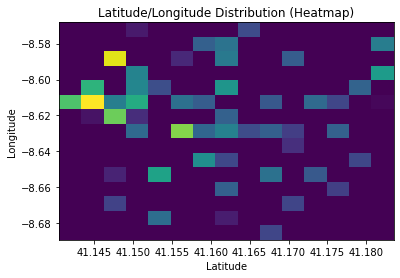

In [30]:
# Heatmap visualization of trip start points
import matplotlib.colors as mcolors
plt.hist2d(latlong[0], latlong[1], bins=15, norm=mcolors.PowerNorm(0.5))
plt.title('Latitude/Longitude Distribution (Heatmap)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# Model training

In [11]:
import xgboost as xgb

dfull_reg = xgb.DMatrix(X, y, enable_categorical=True)
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [12]:
# Hyperparameters
untuned_params = {'eval_metric': 'rmse','objective': 'reg:squarederror', 'tree_method': 'hist'}
params = {'colsample_bytree': 0.8, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 8, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 50.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}

n = 10000
EARLY_STOP = 50

In [13]:
# These are all of the files you are given
# Writing the output to submit to kaggle
df_test = pd.read_csv("kaggle_data/test_public.csv")
titles = df_test['TRIP_ID']
df_test = process_df(df_test)

In [14]:
X_submission = df_test
dsubmission_reg = xgb.DMatrix(X_submission, enable_categorical=True)

In [37]:
# Training and evaluating on the public dataset
from sklearn.model_selection import KFold
# This approach averages the results from each model trained on a different fold of the dataset
nfold=5
kf = KFold(n_splits=nfold, shuffle=True, random_state=1)

predictions = np.zeros(len(df_test))
i = 1
for train_index, valid_index in kf.split(X):
    print("nFold: ", i)
    xg_train = xgb.DMatrix(X.iloc[train_index], y.iloc[train_index], enable_categorical=True)
    xg_valid = xgb.DMatrix(X.iloc[valid_index], y.iloc[valid_index], enable_categorical=True)
    
    model = xgb.train(params, xg_train, num_boost_round=n, evals=[(xg_train, "train"), (xg_valid, "eval")], 
                      early_stopping_rounds=EARLY_STOP, verbose_eval=100)
    predictions += model.predict(dsubmission_reg) / nfold
    i = i + 1

df = pd.DataFrame(data={"TRIP_ID": titles, "TRAVEL_TIME": predictions})
df.to_csv("solution.csv", index=False)

nFold:  1
[0]	train-rmse:769.62330	eval-rmse:770.48691
[100]	train-rmse:392.94627	eval-rmse:395.22050
[200]	train-rmse:386.87928	eval-rmse:390.01041
[300]	train-rmse:385.40859	eval-rmse:389.15654
[400]	train-rmse:384.14552	eval-rmse:388.51499
[500]	train-rmse:383.22450	eval-rmse:388.07839
[600]	train-rmse:382.49173	eval-rmse:387.80249
[700]	train-rmse:381.89298	eval-rmse:387.60864
[800]	train-rmse:381.33563	eval-rmse:387.45357
[900]	train-rmse:380.85036	eval-rmse:387.33177
[1000]	train-rmse:380.42044	eval-rmse:387.24936
[1100]	train-rmse:379.98914	eval-rmse:387.17120
[1200]	train-rmse:379.58028	eval-rmse:387.12189
[1300]	train-rmse:379.22393	eval-rmse:387.08321
[1400]	train-rmse:378.79075	eval-rmse:387.02702
[1500]	train-rmse:378.40995	eval-rmse:386.99912
[1600]	train-rmse:378.06319	eval-rmse:386.98348
[1700]	train-rmse:377.74834	eval-rmse:386.97500
[1800]	train-rmse:377.44026	eval-rmse:386.96749
[1870]	train-rmse:377.19589	eval-rmse:386.96678
nFold:  2
[0]	train-rmse:769.92855	eval-rm

In [49]:
evals_result = {}
# This approach just uses the base train-test split, so it can be saved to memory easier.
model = xgb.train(params, dtrain_reg, num_boost_round=10, evals=[(dtrain_reg, "train"), (dtest_reg, "eval")], 
                      early_stopping_rounds=50, verbose_eval=100, evals_result=evals_result)


[0]	train-rmse:769.60060	eval-rmse:771.49605
[9]	train-rmse:657.65573	eval-rmse:659.67573


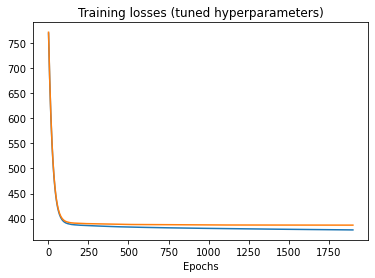

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x_axis = np.arange(1, len(evals_result['train']['rmse']) + 1, 1)
plt.plot(x_axis, evals_result['train']['rmse'])
plt.plot(x_axis, evals_result['eval']['rmse'])
plt.title('Training losses (tuned hyperparameters)')
plt.xlabel("Epochs")
plt.show()

In [32]:
predictions = model.predict(dsubmission_reg)
df = pd.DataFrame(data={"TRIP_ID": titles, "TRAVEL_TIME": predictions})
df.to_csv("solution.csv", index=False)

In [51]:
model.save_model("model.json")

In [71]:
# Experimenting with a different model for each call type
for key, callType in callTypeModels.items():
    callType.evals_result = {}
    dtrain_reg = xgb.DMatrix(callType.X_train, callType.y_train, enable_categorical=True)
    dtest_reg = xgb.DMatrix(callType.X_test, callType.y_test, enable_categorical=True)
    callType.model = xgb.train(params, dtrain_reg, num_boost_round=n, evals=[(dtrain_reg, "train"), (dtest_reg, "eval")], 
                      early_stopping_rounds=50, verbose_eval=100, evals_result=callType.evals_result)

[0]	train-rmse:809.30574	eval-rmse:809.72518
[100]	train-rmse:370.46727	eval-rmse:377.98990
[200]	train-rmse:358.89192	eval-rmse:369.54577
[300]	train-rmse:353.76758	eval-rmse:367.15738
[400]	train-rmse:350.22574	eval-rmse:365.71475
[500]	train-rmse:347.47568	eval-rmse:364.77269
[600]	train-rmse:345.16997	eval-rmse:364.15638
[700]	train-rmse:343.19249	eval-rmse:363.78758
[800]	train-rmse:341.57849	eval-rmse:363.58764
[900]	train-rmse:340.04300	eval-rmse:363.44442
[1000]	train-rmse:338.61419	eval-rmse:363.31403
[1100]	train-rmse:337.41716	eval-rmse:363.30225
[1110]	train-rmse:337.28544	eval-rmse:363.30762
[0]	train-rmse:727.43682	eval-rmse:725.97965
[100]	train-rmse:346.55697	eval-rmse:347.15824
[200]	train-rmse:339.53722	eval-rmse:342.05565
[300]	train-rmse:337.35979	eval-rmse:341.54980
[400]	train-rmse:335.64555	eval-rmse:341.40918
[500]	train-rmse:334.17147	eval-rmse:341.39678
[503]	train-rmse:334.13029	eval-rmse:341.39555
[0]	train-rmse:806.22256	eval-rmse:803.79548
[100]	train-rmse

In [72]:
a_preds = callTypeModels["A"].model.predict(dsubmission_reg)
b_preds = callTypeModels["B"].model.predict(dsubmission_reg)
c_preds = callTypeModels["C"].model.predict(dsubmission_reg)

final_preds = []
for i, row in df_test.iterrows():
    if row['CALL_TYPE'] == 'A':
        final_preds.append(a_preds[i])
    elif row['CALL_TYPE'] == 'B':
        final_preds.append(b_preds[i])
    else:
        final_preds.append(c_preds[i])
        

df = pd.DataFrame(data={"TRIP_ID": titles, "TRAVEL_TIME": final_preds})
df.to_csv("solution.csv", index=False)

# Hyperparameter Optimization

In [ ]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error

xgb.set_config(verbosity=0)

# We use a subset of the data so we can tune hyperparameters faster.
N_HP_DATA = 1000
dtrainHP_reg = xgb.DMatrix(X_train.head(9 * N_HP_DATA), y_train.head(9 * N_HP_DATA), enable_categorical=True)
dtestHP_reg = xgb.DMatrix(X_test.head(N_HP_DATA), y_test.head(N_HP_DATA), enable_categorical=True)

def score(params):
    print("Training with params: ")
    print(params)
    watchlist = [(dtrainHP_reg, 'train'), (dtestHP_reg, 'eval')]
    model = xgb.train(params, dtrainHP_reg, num_boost_round=1000,
                          evals=watchlist, early_stopping_rounds=EARLY_STOP,
                          verbose_eval=100)
    predictions = model.predict(dtestHP_reg, ntree_limit=model.best_iteration + 1)
    rmse = mean_squared_error(y_test.head(N_HP_DATA), predictions, squared=False)
    print("\RMSE {0}\n\n".format(rmse))
    return {'loss': rmse, 'status': STATUS_OK}

def optimize_hyperparams(random_state=314159265):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda': hp.quniform('reg_lambda', 0, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'objective': "reg:squarederror",
        'tree_method': 'hist',
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=50)
    return best

optimize_hyperparams()

Training with params:                                  
{'colsample_bytree': 1.0, 'eta': 0.42500000000000004, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 9, 'min_child_weight': 3.0, 'objective': 'reg:squarederror', 'reg_alpha': 159.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.6000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:795.06506	eval-rmse:717.47849           
[52]	train-rmse:112.11175	eval-rmse:778.82608          
\RMSE 648.9192132128529                                


Training with params:                                                           
{'colsample_bytree': 0.65, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 10, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 111.0, 'reg_lambda': 0.45, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
  1%|          | 1/100 [00:11<19:10, 11.62s/trial, best loss: 648.9192132128529]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:916.27997	eval-rmse:819.46101                                    
[63]	train-rmse:214.63459	eval-rmse:628.96106                                   
\RMSE 593.1924170965558                                                         


Training with params:                                                           
{'colsample_bytree': 0.5, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 2, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 159.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:965.19374	eval-rmse:863.14371                                    
  2%|▏         | 2/100 [00:23<19:06, 11.70s/trial, best loss: 593.1924170965558]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[95]	train-rmse:689.40144	eval-rmse:572.91703                                   
\RMSE 572.0931754588157                                                         


Training with params:                                                           
{'colsample_bytree': 0.6000000000000001, 'eta': 0.47500000000000003, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 6, 'min_child_weight': 1.0, 'objective': 'reg:squarederror', 'reg_alpha': 123.0, 'reg_lambda': 0.15000000000000002, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:795.62562	eval-rmse:689.11423                                    
  3%|▎         | 3/100 [00:24<10:46,  6.66s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[53]	train-rmse:350.09107	eval-rmse:689.29307                                   
\RMSE 612.2615144177147                                                         


Training with params:                                                           
{'colsample_bytree': 0.55, 'eta': 0.42500000000000004, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 9, 'min_child_weight': 1.0, 'objective': 'reg:squarederror', 'reg_alpha': 170.0, 'reg_lambda': 0.9500000000000001, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
  4%|▍         | 4/100 [00:25<07:36,  4.75s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:784.02546	eval-rmse:710.89962                                    
[54]	train-rmse:135.49528	eval-rmse:656.34420                                   
\RMSE 615.1124573360802                                                         


Training with params:                                                           
{'colsample_bytree': 1.0, 'eta': 0.4, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 2, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 135.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:830.06319	eval-rmse:715.76572                                    
  5%|▌         | 5/100 [00:31<07:53,  4.98s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[55]	train-rmse:678.89230	eval-rmse:580.37883                                   
\RMSE 574.3715967912262                                                         


Training with params:                                                           
{'colsample_bytree': 0.6000000000000001, 'eta': 0.4, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 12, 'min_child_weight': 2.0, 'objective': 'reg:squarederror', 'reg_alpha': 83.0, 'reg_lambda': 0.7000000000000001, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
  6%|▌         | 6/100 [00:31<05:30,  3.52s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:799.72076	eval-rmse:706.48823                                    
[55]	train-rmse:73.15374	eval-rmse:645.66143                                    
\RMSE 601.3638661142601                                                         


Training with params:                                                           
{'colsample_bytree': 0.55, 'eta': 0.47500000000000003, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 12, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 145.0, 'reg_lambda': 1.0, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
  7%|▋         | 7/100 [00:50<12:58,  8.37s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:788.93748	eval-rmse:680.01546                                    
[52]	train-rmse:91.59471	eval-rmse:687.91564                                    
\RMSE 603.223495598593                                                          


Training with params:                                                           
{'colsample_bytree': 0.5, 'eta': 0.35000000000000003, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 7, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 97.0, 'reg_lambda': 0.8500000000000001, 'seed': 314159265, 'subsample': 0.5, 'tree_method': 'hist'}
[0]	train-rmse:841.67535	eval-rmse:739.87725                                    
  8%|▊         | 8/100 [01:04<15:51, 10.34s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[54]	train-rmse:434.36951	eval-rmse:671.56868                                   
\RMSE 600.0324981620545                                                         


Training with params:                                                           
{'colsample_bytree': 0.65, 'eta': 0.325, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 1, 'min_child_weight': 4.0, 'objective': 'reg:squarederror', 'reg_alpha': 98.0, 'reg_lambda': 0.5, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:862.24398	eval-rmse:748.78975                                    
  9%|▉         | 9/100 [01:07<11:49,  7.80s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:697.95335	eval-rmse:573.73440                                  
[156]	train-rmse:697.74113	eval-rmse:573.94935                                  
\RMSE 573.065446188512                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.45, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 7, 'min_child_weight': 4.0, 'objective': 'reg:squarederror', 'reg_alpha': 84.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
[0]	train-rmse:789.19315	eval-rmse:683.96396                                     
 10%|█         | 10/100 [01:07<08:23,  5.59s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[52]	train-rmse:243.42547	eval-rmse:686.45295                                    
\RMSE 582.0874004796375                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 4, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 136.0, 'reg_lambda': 0.55, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
[0]	train-rmse:904.84716	eval-rmse:796.76539                                     
 11%|█         | 11/100 [01:11<07:15,  4.90s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[64]	train-rmse:592.24241	eval-rmse:586.42369                                    
\RMSE 575.4842504608847                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 2, 'min_child_weight': 1.0, 'objective': 'reg:squarederror', 'reg_alpha': 58.0, 'reg_lambda': 0.9500000000000001, 'seed': 314159265, 'subsample': 0.6000000000000001, 'tree_method': 'hist'}
[0]	train-rmse:904.20808	eval-rmse:798.42695                                     
 12%|█▏        | 12/100 [01:11<05:23,  3.67s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[70]	train-rmse:665.98011	eval-rmse:579.48068                                    
\RMSE 574.693001586096                                                           


Training with params:                                                            
{'colsample_bytree': 0.9, 'eta': 0.30000000000000004, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 10, 'min_child_weight': 3.0, 'objective': 'reg:squarederror', 'reg_alpha': 123.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 13%|█▎        | 13/100 [01:12<04:03,  2.80s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:837.71970	eval-rmse:765.36267                                     
[53]	train-rmse:82.64581	eval-rmse:646.34802                                     
\RMSE 613.2437451305824                                                          


Training with params:                                                            
{'colsample_bytree': 0.9500000000000001, 'eta': 0.375, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 7, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 56.0, 'reg_lambda': 0.9500000000000001, 'seed': 314159265, 'subsample': 0.55, 'tree_method': 'hist'}
[0]	train-rmse:829.32219	eval-rmse:733.31357                                     
 14%|█▍        | 14/100 [01:27<09:09,  6.39s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[53]	train-rmse:314.35708	eval-rmse:671.94194                                    
\RMSE 592.8868463697313                                                          


Training with params:                                                            
{'colsample_bytree': 0.9, 'eta': 0.225, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 10, 'min_child_weight': 1.0, 'objective': 'reg:squarederror', 'reg_alpha': 155.0, 'reg_lambda': 0.25, 'seed': 314159265, 'subsample': 0.65, 'tree_method': 'hist'}
 15%|█▌        | 15/100 [01:31<07:54,  5.58s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:873.77623	eval-rmse:808.94198                                     
[61]	train-rmse:108.55083	eval-rmse:677.19991                                    
\RMSE 637.8758418982109                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.42500000000000004, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 6, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 155.0, 'reg_lambda': 0.8, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
[0]	train-rmse:811.98884	eval-rmse:708.39969                                     
 16%|█▌        | 16/100 [01:45<11:37,  8.31s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[53]	train-rmse:368.00629	eval-rmse:625.49279                                    
\RMSE 591.9112184320458                                                          


Training with params:                                                            
{'colsample_bytree': 0.9, 'eta': 0.275, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'max_depth': 9, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 173.0, 'reg_lambda': 0.9, 'seed': 314159265, 'subsample': 0.8, 'tree_method': 'hist'}
 17%|█▋        | 17/100 [01:47<08:46,  6.34s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:867.97822	eval-rmse:768.93264                                     
[62]	train-rmse:144.75385	eval-rmse:624.37944                                    
\RMSE 573.4047755804925                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.42500000000000004, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 1, 'min_child_weight': 4.0, 'objective': 'reg:squarederror', 'reg_alpha': 113.0, 'reg_lambda': 0.65, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:823.63146	eval-rmse:705.06680                                     
 18%|█▊        | 18/100 [01:57<10:17,  7.53s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[82]	train-rmse:697.03173	eval-rmse:574.30792                                    
\RMSE 573.1089135484405                                                          


Training with params:                                                            
{'colsample_bytree': 0.9, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 11, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 102.0, 'reg_lambda': 1.0, 'seed': 314159265, 'subsample': 0.5, 'tree_method': 'hist'}
 19%|█▉        | 19/100 [01:58<07:16,  5.39s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:907.70138	eval-rmse:817.13814                                     
[62]	train-rmse:250.54683	eval-rmse:635.01711                                    
\RMSE 588.8996582424066                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 13, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 69.0, 'reg_lambda': 0.45, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
 20%|██        | 20/100 [02:14<11:44,  8.80s/trial, best loss: 572.0931754588157]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:971.90830	eval-rmse:874.97061                                     
[85]	train-rmse:306.58294	eval-rmse:582.10937                                    
\RMSE 567.5032348528035                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 13, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 42.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 21%|██        | 21/100 [02:46<20:24, 15.49s/trial, best loss: 567.5032348528035]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:985.19957	eval-rmse:891.27824                                     
[100]	train-rmse:284.19859	eval-rmse:578.28998                                   
[104]	train-rmse:276.81303	eval-rmse:579.37298                                   
\RMSE 564.2782601205637                                                          


Training with params:                                                            
{'colsample_bytree': 0.8500000000000001, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 1.0, 'max_depth': 13, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 43.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 0.7000000000000001, 'tree_method': 'hist'}
 22%|██▏       | 22/100 [03:31<31:54, 24.54s/trial, best loss: 564.2782601205637]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:985.42905	eval-rmse:888.81225                                     
[100]	train-rmse:330.73863	eval-rmse:577.11212                                   
[102]	train-rmse:326.87371	eval-rmse:577.02190                                   
\RMSE 569.4707866315189                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 13, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 45.0, 'reg_lambda': 0.0, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 23%|██▎       | 23/100 [04:17<39:51, 31.06s/trial, best loss: 564.2782601205637]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:1000.57580	eval-rmse:904.87888                                    
[100]	train-rmse:428.06014	eval-rmse:569.51645                                   
[200]	train-rmse:288.78062	eval-rmse:567.45955                                   
[242]	train-rmse:249.04199	eval-rmse:567.84914                                   
\RMSE 566.7946484515608                                                          


Training with params:                                                              
{'colsample_bytree': 0.8500000000000001, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 13, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 40.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 24%|██▍       | 24/100 [06:01<1:06:53, 52.81s/trial, best loss: 564.2782601205637]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:939.18647	eval-rmse:849.78443                                       
[79]	train-rmse:145.79297	eval-rmse:601.54143                                      
\RMSE 585.4425892203725                                                            


Training with params:                                                              
{'colsample_bytree': 0.8, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 8, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 50.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 25%|██▌       | 25/100 [06:36<59:18, 47.45s/trial, best loss: 564.2782601205637]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:1001.67997	eval-rmse:904.72783                                    
[100]	train-rmse:529.81119	eval-rmse:562.67870                                   
[200]	train-rmse:422.55397	eval-rmse:560.85726                                   
[224]	train-rmse:402.53506	eval-rmse:560.26631                                   
\RMSE 559.2754636485857                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 8, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 67.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 26%|██▌       | 26/100 [06:56<48:19, 39.19s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:945.16731	eval-rmse:850.14611                                     
[67]	train-rmse:337.27413	eval-rmse:586.27314                                    
\RMSE 581.7381189000331                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 2.0, 'objective': 'reg:squarederror', 'reg_alpha': 53.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 27%|██▋       | 27/100 [07:01<35:24, 29.10s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:1000.22597	eval-rmse:904.84065                                    
[100]	train-rmse:482.62517	eval-rmse:570.32269                                   
[156]	train-rmse:417.49582	eval-rmse:572.69670                                   
\RMSE 569.6546532416578                                                          


Training with params:                                                            
{'colsample_bytree': 0.8500000000000001, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 8, 'min_child_weight': 3.0, 'objective': 'reg:squarederror', 'reg_alpha': 79.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 28%|██▊       | 28/100 [07:14<28:49, 24.02s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:927.88115	eval-rmse:829.96030                                     
[65]	train-rmse:244.01673	eval-rmse:595.05810                                    
\RMSE 576.6342736579926                                                          


Training with params:                                                            
{'colsample_bytree': 1.0, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.9, 'max_depth': 3, 'min_child_weight': 4.0, 'objective': 'reg:squarederror', 'reg_alpha': 71.0, 'reg_lambda': 0.05, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:976.98727	eval-rmse:876.92975                                     
 29%|██▉       | 29/100 [07:20<22:18, 18.86s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[89]	train-rmse:663.93517	eval-rmse:580.35930                                    
\RMSE 574.3853743651019                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 5, 'min_child_weight': 2.0, 'objective': 'reg:squarederror', 'reg_alpha': 50.0, 'reg_lambda': 0.35000000000000003, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
[0]	train-rmse:989.64061	eval-rmse:890.65689                                     
 30%|███       | 30/100 [07:22<15:53, 13.62s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:595.97052	eval-rmse:573.85424                                   
[157]	train-rmse:559.51147	eval-rmse:576.47892                                   
\RMSE 572.698408626817                                                           


Training with params:                                                            
{'colsample_bytree': 0.9500000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 4, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 60.0, 'reg_lambda': 0.2, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
[0]	train-rmse:926.88401	eval-rmse:823.62450                                     
 31%|███       | 31/100 [07:26<12:20, 10.73s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[67]	train-rmse:593.60999	eval-rmse:600.59640                                    
\RMSE 584.0879530341552                                                          


Training with params:                                                            
{'colsample_bytree': 0.8, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 8, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 92.0, 'reg_lambda': 0.15000000000000002, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 32%|███▏      | 32/100 [07:27<09:00,  7.96s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:958.10685	eval-rmse:859.72670                                     
[81]	train-rmse:347.76217	eval-rmse:586.56759                                    
\RMSE 570.4105077331066                                                          


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.025, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 5, 'min_child_weight': 4.0, 'objective': 'reg:squarederror', 'reg_alpha': 75.0, 'reg_lambda': 0.25, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
[0]	train-rmse:1002.79665	eval-rmse:904.57385                                    
 33%|███▎      | 33/100 [07:34<08:33,  7.66s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[100]	train-rmse:643.37029	eval-rmse:572.50675                                   
[196]	train-rmse:597.74834	eval-rmse:570.96615                                   
\RMSE 570.365994714708                                                           


Training with params:                                                            
{'colsample_bytree': 0.8500000000000001, 'eta': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 11, 'min_child_weight': 3.0, 'objective': 'reg:squarederror', 'reg_alpha': 63.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
 34%|███▍      | 34/100 [07:39<07:23,  6.72s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:925.33460	eval-rmse:833.19272                                     
[62]	train-rmse:132.93707	eval-rmse:608.55412                                    
\RMSE 586.8956943164046                                                          


Training with params:                                                            
{'colsample_bytree': 0.9500000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 1.0, 'max_depth': 6, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 89.0, 'reg_lambda': 0.45, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:975.85704	eval-rmse:876.55122                                     
 35%|███▌      | 35/100 [08:03<12:51, 11.88s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[80]	train-rmse:507.80132	eval-rmse:588.13778                                    
\RMSE 580.6400960813613                                                          


Training with params:                                                            
{'colsample_bytree': 0.7000000000000001, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 3, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 41.0, 'reg_lambda': 0.1, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
[0]	train-rmse:964.85460	eval-rmse:862.83700                                     
 36%|███▌      | 36/100 [08:06<10:03,  9.43s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[79]	train-rmse:667.06982	eval-rmse:576.54192                                    
\RMSE 574.2965279157859                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 9, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 105.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 37%|███▋      | 37/100 [08:08<07:16,  6.92s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:988.22784	eval-rmse:890.70098                                     
[100]	train-rmse:417.61376	eval-rmse:562.80567                                   
[145]	train-rmse:351.09192	eval-rmse:565.37652                                   
\RMSE 562.1576748326638                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 9, 'min_child_weight': 2.0, 'objective': 'reg:squarederror', 'reg_alpha': 115.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 38%|███▊      | 38/100 [08:24<10:05,  9.76s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:912.32677	eval-rmse:816.12541                                     
[72]	train-rmse:178.77867	eval-rmse:594.92598                                    
\RMSE 574.2620327086063                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.275, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 9, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 106.0, 'reg_lambda': 0.75, 'seed': 314159265, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}
 39%|███▉      | 39/100 [08:32<09:21,  9.21s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:871.43610	eval-rmse:777.68629                                     
[62]	train-rmse:235.76785	eval-rmse:614.59711                                    
\RMSE 595.6170865012257                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 9, 'min_child_weight': 4.0, 'objective': 'reg:squarederror', 'reg_alpha': 121.0, 'reg_lambda': 0.5, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
 40%|████      | 40/100 [08:38<08:19,  8.33s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:945.98383	eval-rmse:850.04445                                     
[71]	train-rmse:272.07524	eval-rmse:583.08365                                    
\RMSE 575.3024459964574                                                          


Training with params:                                                            
{'colsample_bytree': 0.55, 'eta': 0.25, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 12, 'min_child_weight': 6.0, 'objective': 'reg:squarederror', 'reg_alpha': 143.0, 'reg_lambda': 0.6000000000000001, 'seed': 314159265, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}
 41%|████      | 41/100 [08:46<08:06,  8.25s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:884.01707	eval-rmse:780.67612                                     
[55]	train-rmse:164.87739	eval-rmse:641.81789                                    
\RMSE 599.541189539703                                                           


Training with params:                                                            
{'colsample_bytree': 0.65, 'eta': 0.5, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 2, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 164.0, 'reg_lambda': 0.4, 'seed': 314159265, 'subsample': 1.0, 'tree_method': 'hist'}
[0]	train-rmse:796.56364	eval-rmse:675.18479                                     
 42%|████▏     | 42/100 [09:01<10:00, 10.36s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[56]	train-rmse:672.49047	eval-rmse:579.21788                                    
\RMSE 575.6648041901664                                                          


Training with params:                                                            
{'colsample_bytree': 0.75, 'eta': 0.325, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 3.0, 'objective': 'reg:squarederror', 'reg_alpha': 130.0, 'reg_lambda': 0.30000000000000004, 'seed': 314159265, 'subsample': 0.65, 'tree_method': 'hist'}
 43%|████▎     | 43/100 [09:02<07:03,  7.42s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:835.71609	eval-rmse:757.32102                                     
[53]	train-rmse:218.73453	eval-rmse:664.27170                                    
\RMSE 597.3574849841507                                                          


Training with params:                                                            
{'colsample_bytree': 0.6000000000000001, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 9, 'min_child_weight': 5.0, 'objective': 'reg:squarederror', 'reg_alpha': 131.0, 'reg_lambda': 0.25, 'seed': 314159265, 'subsample': 0.9, 'tree_method': 'hist'}
 44%|████▍     | 44/100 [09:08<06:26,  6.89s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	train-rmse:906.81915	eval-rmse:806.21895                                     
[61]	train-rmse:243.12432	eval-rmse:613.21212                                    
\RMSE 585.3209971733853                                                          


Training with params:                                                            
{'colsample_bytree': 0.5, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 1, 'min_child_weight': 4.0, 'objective': 'reg:squarederror', 'reg_alpha': 148.0, 'reg_lambda': 0.7000000000000001, 'seed': 314159265, 'subsample': 0.75, 'tree_method': 'hist'}
[0]	train-rmse:965.41134	eval-rmse:863.34092                                     
 45%|████▌     | 45/100 [09:15<06:23,  6.98s/trial, best loss: 559.2754636485857]

/home/acz001/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[98]	train-rmse:700.06555	eval-rmse:573.21680                                    
\RMSE 572.3488045194835                                                          


 46%|████▌     | 46/100 [09:15<04:31,  5.03s/trial, best loss: 559.2754636485857]

In [ ]:
# Hyperparameter evaluation with k-fold cross validation
results = xgb.cv(
   params, dtest_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=EARLY_STOP,
)

print(results['test-rmse-mean'].mean())
print(results.head())

# Final model evaluation

In [47]:
# Randomly sample a few training samples after the training has finished.
sample = df_tr.sample(n=10, ignore_index=True)
X_sample = sample.drop('LEN', axis=1)
y_sample = sample['LEN']

dsample = xgb.DMatrix(X_sample, enable_categorical=True)
y_sample_pred = model.predict(dsample)


y_sample = y_sample.rename("Actual")
predicted = pd.DataFrame(y_sample_pred, columns=["Predicted"])
pd.concat([sample, y_sample, predicted], axis=1)

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TIMESTAMP,LEN,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK,Actual,Predicted
0,A,14828.0,NaN,1376132285,630.0,0.000000,0.000000,2013,8,10,10,5,630.0,685.038513
1,B,NaN,36.0,1382364132,795.0,41.154657,-8.649074,2013,10,21,14,0,795.0,712.103210
2,A,3182.0,NaN,1397757583,1335.0,0.000000,0.000000,2014,4,17,17,3,1335.0,909.968628
3,A,29898.0,NaN,1402815978,660.0,0.000000,0.000000,2014,6,15,7,6,660.0,660.593262
4,C,NaN,NaN,1388559741,270.0,0.000000,0.000000,2014,1,1,7,2,270.0,682.460632
5,C,NaN,NaN,1381457038,585.0,0.000000,0.000000,2013,10,11,2,4,585.0,571.911377
6,C,NaN,NaN,1379225080,105.0,0.000000,0.000000,2013,9,15,6,6,105.0,616.452393
7,C,NaN,NaN,1390429656,375.0,0.000000,0.000000,2014,1,22,22,2,375.0,589.741943
8,C,NaN,NaN,1400260988,1110.0,0.000000,0.000000,2014,5,16,17,4,1110.0,779.140564
9,C,NaN,NaN,1383443531,630.0,0.000000,0.000000,2013,11,3,1,6,630.0,607.039551


In [134]:
# Final testing on all data
batch_size = 128

test_dataset = ModelDataset(mode='test', raw_data = raw_train)

highest_loss = []
for i in range(len(test_dataset)):
    model.eval()
    x, t, raw = test_dataset[i]
    y = model(x.unsqueeze(0))
    loss = loss_function(torch.tensor(y.item()).to(device), t)
    highest_loss = sorted(highest_loss + [(loss, raw)], key=lambda x: -x[0])[:10]
print(highest_loss)

[(tensor(57586.3359, device='cuda:0'), TRIP_ID                                       1393061275620000681
CALL_TYPE                                                       C
ORIGIN_CALL                                                   NaN
ORIGIN_STAND                                                  NaN
TAXI_ID                                                  20000681
TIMESTAMP                                              1393061275
DAY_TYPE                                                        A
MISSING_DATA                                                False
POLYLINE        [[-8.583435,41.158665],[-8.582958,41.158899],[...
LEN                                                         58200
Name: 1093727, dtype: object), (tensor(57451.5039, device='cuda:0'), TRIP_ID                                       1400312076620000562
CALL_TYPE                                                       C
ORIGIN_CALL                                                   NaN
ORIGIN_STAND                      

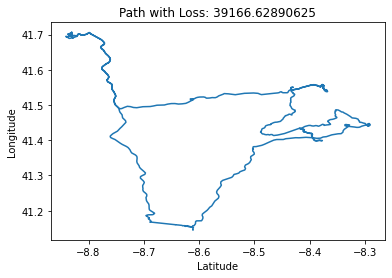

In [172]:
# Visualize paths of biggest outliers
loss, row = highest_loss[9]
count += 1
polyline = row['POLYLINE'].split("],")
polyline = [i.replace("[", '').replace("]", '') for i in polyline]
polyline = [(float(i.split(",")[0]), float(i.split(",")[1])) for i in polyline]
lat = [i[0] for i in polyline]
lon = [i[1] for i in polyline]
plt.plot(lat, lon)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title(f'Path with Loss: {loss}')
plt.show()